In [1]:
import seaborn as sns
from software.data_collector import get_data_for_period
from software.data_processor import process_data
# from software.backtester import run_back_test
from software.plotter import plot_bollinger_bands, plot_ema_and_sma, plot_rsi, plot_atr, plot_signals
from software.strategy_buy import Strategy
from software.tasks import execute_trades
from software.analysis import evaluate_performance

%matplotlib inline
sns.set_style('darkgrid')

ticker = "BTC-USD"
start_date = "2024-11-02 20:00:00"
end_date = "2024-11-04 01:30:00"
interval = "1m"

sma_period=5
ema_period=20
rsi_period=7
bbands_period=20
atr_period=14

initial_cash = 3000
transaction_cost = 0.001
leverage=1
slippage_pct=0.0005
risk_per_trade=0.02

data = get_data_for_period(ticker=ticker, start_date=start_date, end_date=end_date, interval=interval)
processed_data = process_data(
    data,
    sma_period=sma_period,
    ema_period=ema_period,
    rsi_period=rsi_period,
    bbands_period=bbands_period,
    atr_period=atr_period,
)

strategy = Strategy(
    ema_sma_threshold=0,
    rsi_long_threshold=40,
    rsi_short_threshold=60,
    bb_threshold=0,
)


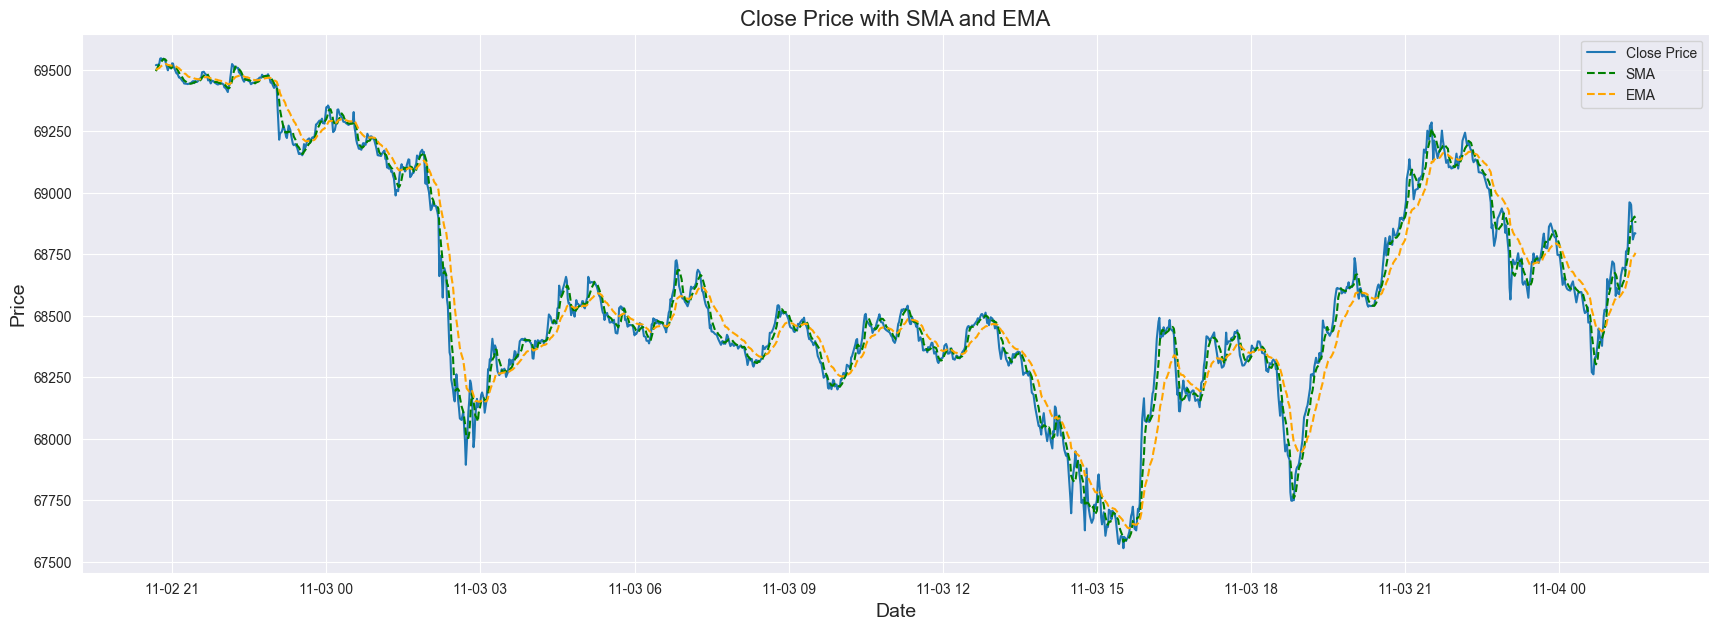

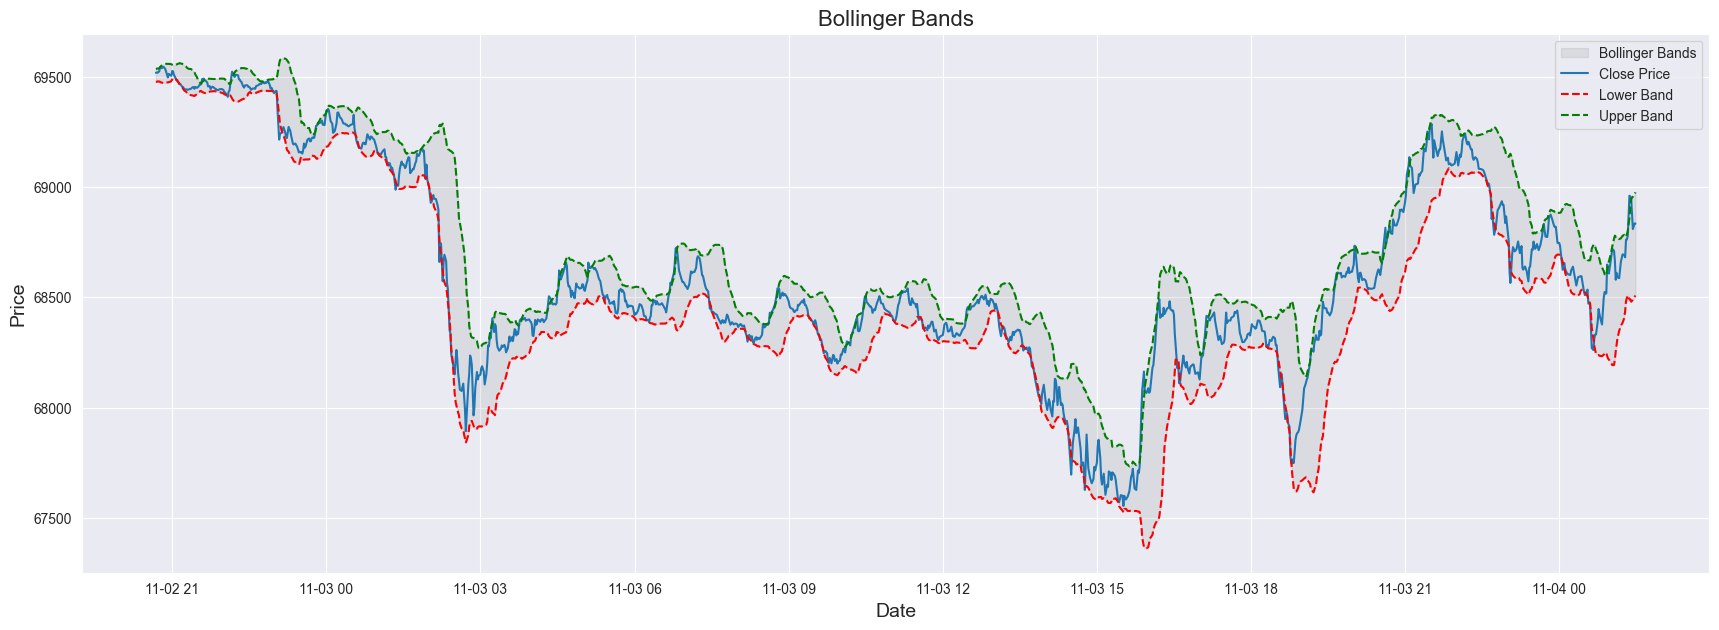

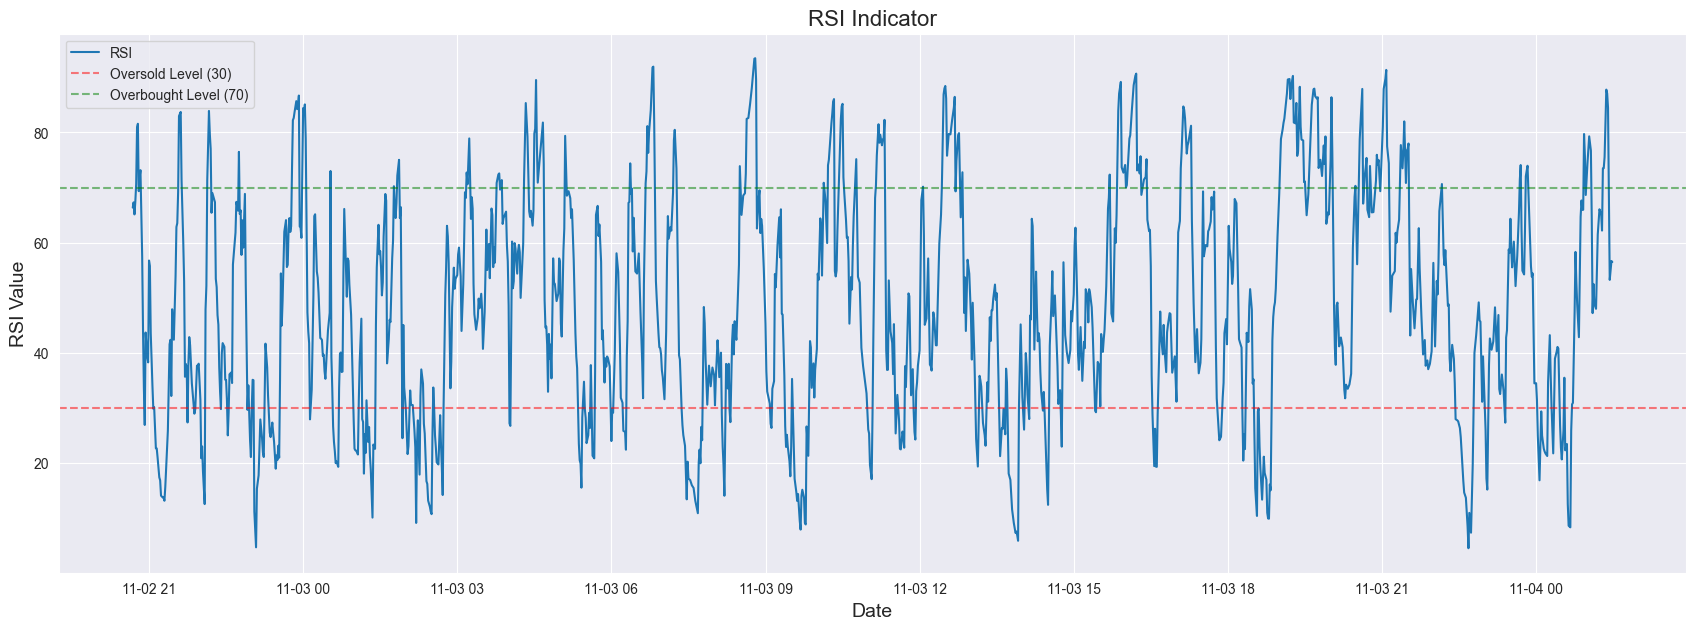

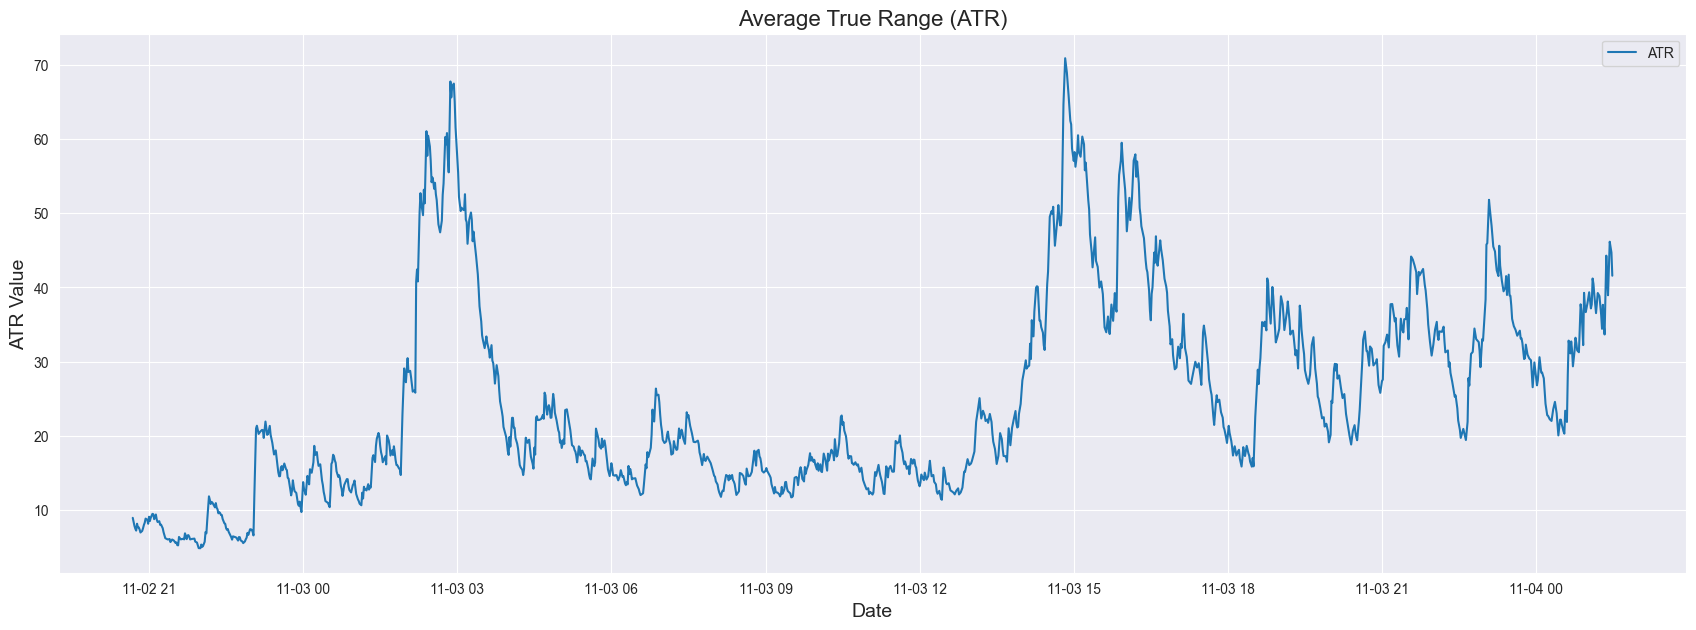

In [2]:
plot_ema_and_sma(processed_data)
plot_bollinger_bands(processed_data)
plot_rsi(processed_data)
plot_atr(processed_data)

In [3]:
data_with_signals = strategy.generate_buy_signals(processed_data)

Signals : [0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, -1, 0, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1,

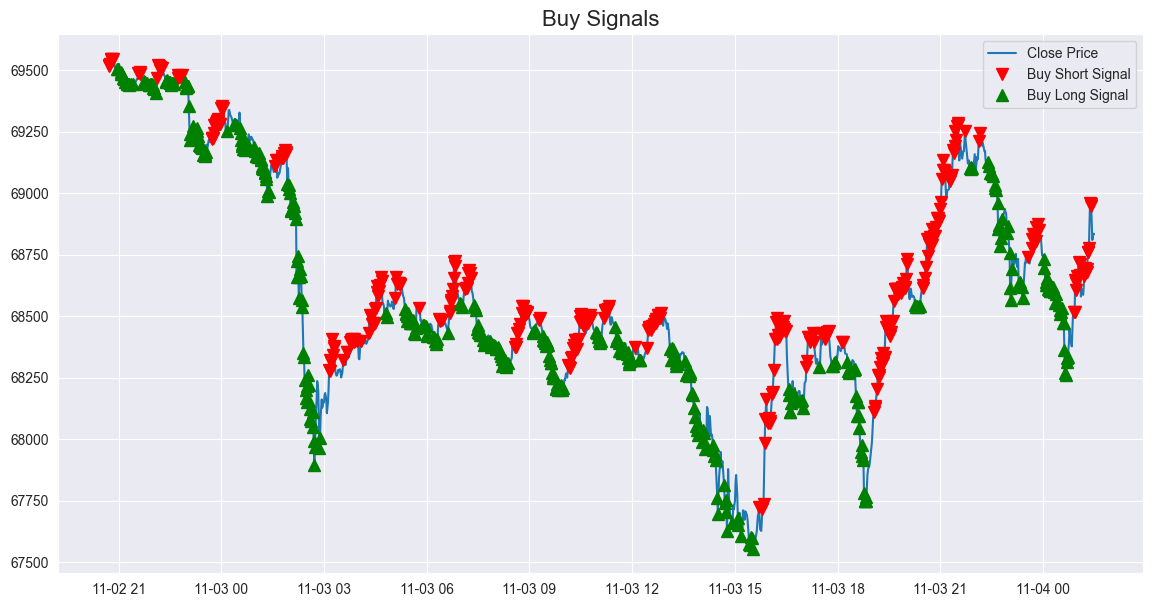

In [4]:
print("Signals :", data_with_signals["Signal"].tolist())
plot_signals(processed_data)

In [5]:
# transactions, equity_curve, dates = execute_trades(
#     data=data_with_signals,
#     initial_cash=initial_cash,
#     transaction_cost=transaction_cost,
#     leverage=leverage,
#     slippage_pct=slippage_pct,
#     risk_per_trade=risk_per_trade,
# )

from software.executor import TradingExecutor
from tqdm import tqdm

executor = TradingExecutor(
    initial_cash=initial_cash,
    transaction_cost=transaction_cost,
    leverage=leverage,
    slippage_pct=slippage_pct,
    risk_per_trade=risk_per_trade,
)

transactions = []
equity_curve = []
dates = []

print("Executor :", executor.__dict__)

Executor : {'cash': 3000, 'transaction_cost': 0.001, 'leverage': 1, 'slippage_pct': 0.0005, 'risk_per_trade': 0.02, 'positions': [], 'history': []}


In [ ]:
for index, row in tqdm(
    data_with_signals.iterrows(),
    total=len(data_with_signals),
    desc="Executing trades",
):
    signal = row["Signal"]
    price = row["Close"]
    date = index

    # Cas 1 : pas de position ouverte, signal d'achat
    # Cas 2 : 

    if executor.positions or signal != 0:
        print("Positions :", executor.positions, "Calculating Stop Loss...")
        stop_loss_price = executor.calculate_stop_loss(price=price, row=row, signal=signal, risk_factor=0.02)
        print("Stop Loss Price :", stop_loss_price)
    if signal != 0:
        print("Signal diff from 0 :", signal, "Stop Loss Price :", stop_loss_price)
        # print("Rows :", row)
        executor.execute_signal(
            signal,
            price,
            stop_loss_price,
            date,
        )

    if executor.positions:
        print("Positions :", executor.positions)
        executor.update_positions(price, date, stop_loss_price)
    executor.update_positions(price, date, stop_loss_price)

    if executor.history and (
        not transactions or executor.history[-1] != transactions[-1]
    ):
        last_transaction = executor.history[-1]
        transactions.append(last_transaction)

    total_value = executor.get_total_portfolio_value(price)
    equity_curve.append(total_value)
    dates.append(date)

Executing trades:   1%|▏                 | 10/1250 [00:00<00:00, 2528.36it/s]

Signal is 0 and we have no positions
No action taken
Signal is 0 and we have no positions
No action taken
Signal diff from 0 : -1.0
Calculating Stop Loss...
Stop Loss Price : 70923.8263967663
Executing Signal...
Opening short position at 69517.828125 stop loss at 70923.8263967663
Position size in USD: 2893.61
Payed price:  2893.61
Cash rest:  106.38999999999987
Price:  69483.06921093751
Stop loss:  70923.8263967663
Opened short position at $69483.07 with a stop loss at $70923.83
Signal diff from 0 : -1.0
Calculating Stop Loss...
Stop Loss Price : 70926.11884042592
Executing Signal...
Signal diff from 0 : -1.0
Calculating Stop Loss...
Stop Loss Price : 70929.82793209847
Executing Signal...
Signal diff from 0 : -1.0
Calculating Stop Loss...
Stop Loss Price : 70951.47767394422
Executing Signal...
Signal diff from 0 : -1.0
Calculating Stop Loss...
Stop Loss Price : 70952.32605374843
Executing Signal...
Signal diff from 0 : -1.0
Calculating Stop Loss...
Stop Loss Price : 70944.68164230516
E

TypeError: TradingExecutor.update_positions() missing 1 required positional argument: 'stop_loss_price'

In [ ]:
print("Transactions :", transactions)
print("Equity curve :", equity_curve)
print("Dates :", dates)



Transactions : []
Equity curve : [3000.0, 3000.0]
Dates : [Timestamp('2024-11-02 20:41:00+0000', tz='UTC'), Timestamp('2024-11-02 20:42:00+0000', tz='UTC')]


In [ ]:
performance_metrics = evaluate_performance(
    transactions, equity_curve, initial_cash
)

final_portfolio_value = equity_curve[-1]
total_profit = final_portfolio_value - initial_cash
print(f"Total Profit: ${total_profit:.2f}")

Total Profit: $0.00


/Users/ju/Works/perso/algo_day_trading/software/analysis.py:57: RuntimeWarning: invalid value encountered in scalar divide
  return excess_returns.mean() / excess_returns.std()


KeyError: 'Short'

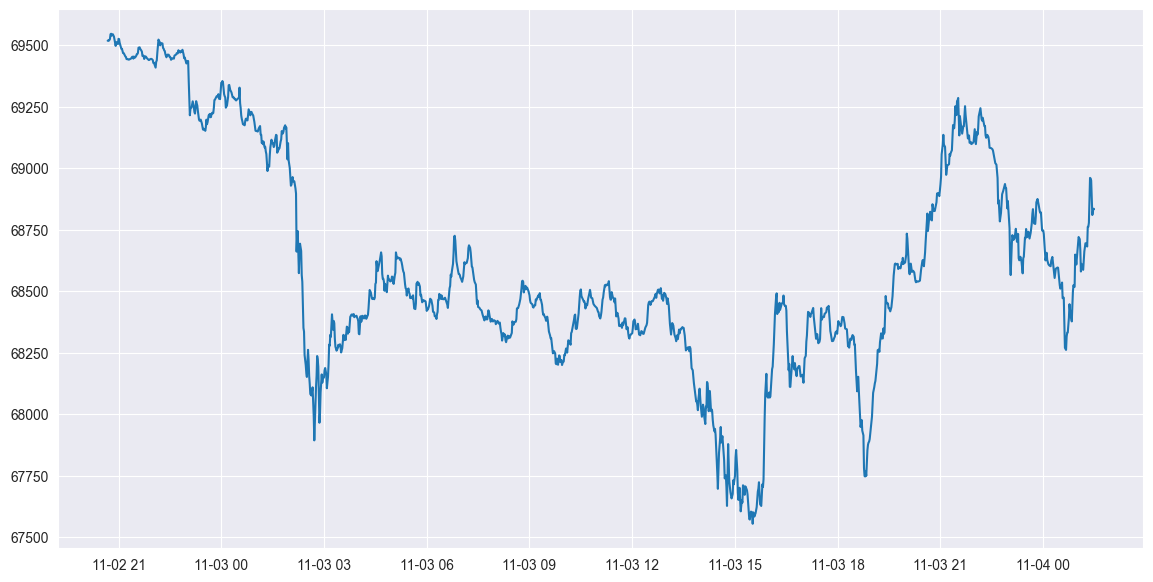

In [ ]:
from software.plotter import plot_trades, plot_equity_curve

plot_trades(price_data=processed_data, transactions=transactions)
plot_equity_curve(dates, equity_curve)

- Add test and documentation to get a 100% coverage.
- Adjust the slippage.
- Add percentage of success trades.
- Add parameter to adjust the whole strategy.
- Add parameter to adjust the stop loss.
- Add indicator to adjust the strategy.
- Make every parameter adjustable in the strategy.
- Add model to adjust the strategy.
- List patterns of the close prices.
- Recognize the patterns with a classifier.
- Adapt the strategy to the patterns.
- Train each model with every pattern to get the best strategy.
- Match the best strategy with the current pattern.
- Add GPT api to adjust the risk by the news.